In [38]:
import warnings
warnings.filterwarnings(action='ignore')

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from bot.config.settings import Settings
from bot.core.encoder import TextEncoder
from bot.data.dataset import DatasetManager
from bot.model.utils import read_best_params
from sklearn.model_selection import (StratifiedKFold, cross_val_score, train_test_split)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
encoder = TextEncoder(Settings.MODEL_CLS)
root = Path().cwd().parent # дефолтный путь не подходит
dm = DatasetManager(path=root / "data/data.csv")
X, y = encoder.encode(dm.get_X()), dm.get_y()
X_tain, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=Settings.RNG_INT, shuffle=True, stratify=y)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=Settings.RNG_INT)

In [24]:
X_tain.shape, X_test.shape

((490, 312), (55, 312))

In [25]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(label
 0    0.595918
 1    0.404082
 Name: proportion, dtype: float64,
 label
 0    0.6
 1    0.4
 Name: proportion, dtype: float64)

In [30]:
best_params = read_best_params(root / "bot/model/optunalogs/linear_svc_1742725246.json")
clf = LinearSVC(**best_params, max_iter=10_000, random_state=Settings.RNG_INT)

In [27]:
f1_scores = cross_val_score(clf, X, y, cv=cv, scoring='f1')
recall_scores = cross_val_score(clf, X, y, cv=cv, scoring='recall')
precision_scores = cross_val_score(clf, X, y, cv=cv, scoring='precision')

print(f"f1: {f1_scores.mean()} +/- {f1_scores.std()}")
print(f"recall: {recall_scores.mean()} +/- {recall_scores.std()}")
print(f"precision: {precision_scores.mean()} +/- {precision_scores.std()}")

f1: 0.9662174149285567 +/- 0.017515996331945963
recall: 0.9681818181818181 +/- 0.02910511017014931
precision: 0.966227931488801 +/- 0.03995185715632495


In [32]:
clf_calib = CalibratedClassifierCV(clf, method="sigmoid", cv=cv, ensemble=True, n_jobs=5)
clf_calib.fit(X_tain, y_train)

CalibratedClassifierCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                       ensemble=True,
                       estimator=LinearSVC(C=17.31881036840875, loss='hinge',
                                           max_iter=10000, random_state=42),
                       n_jobs=5)

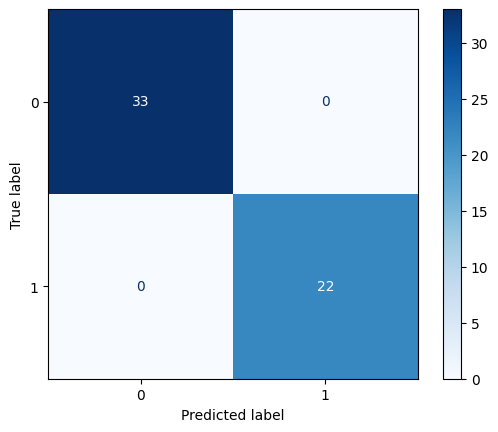

In [35]:
ConfusionMatrixDisplay.from_estimator(clf_calib, X_test, y_test, cmap='Blues')
plt.show()

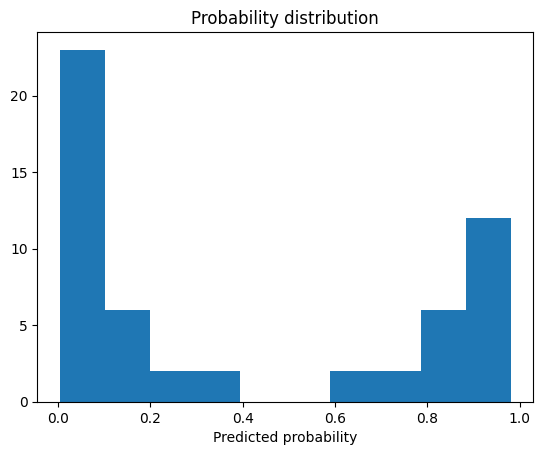

In [42]:
proba = clf_calib.predict_proba(X_test)[:, 1]
plt.hist(proba)
plt.xlabel("Predicted probability")
plt.title("Probability distribution")
plt.show()